### STEP : Taxonomic assignment
#### Taxonomic assignment with Silva 16S

Using Silva 16S classifier for Qiime2. List with all [classifiers](https://docs.qiime2.org/2020.6/data-resources/). 

#### Versions 
- [Silva 138 99% OTUs full-length sequences](https://data.qiime2.org/2020.6/common/silva-138-99-nb-classifier.qza)
- [Silva 138 99% OTUs from 515F/806R region of sequences](https://data.qiime2.org/2020.6/common/silva-138-99-515-806-nb-classifier.qza)
- [Greengenes 13_8 99% OTUs full-length sequences](https://data.qiime2.org/2020.6/common/gg-13-8-99-nb-classifier.qza)
- [Greengenes 13_8 99% OTUs from 515F/806R region of sequences](https://data.qiime2.org/2020.6/common/gg-13-8-99-515-806-nb-classifier.qza)

#### Methods
- [qiime feature-classifier](https://docs.qiime2.org/2022.2/plugins/available/feature-classifier/)
- [qiime feature-classifier classify-sklearn](https://docs.qiime2.org/2021.8/plugins/available/feature-classifier/classify-sklearn)
- [qiime metadata](https://docs.qiime2.org/2022.2/plugins/available/metadata/)
- [classify-hybrid-vsearch-sklearn](https://docs.qiime2.org/2022.2/plugins/available/feature-classifier/classify-hybrid-vsearch-sklearn/)
- [qiime metadata tabulate](https://docs.qiime2.org/2022.2/plugins/available/metadata/tabulate/)
- [qiime taxa](https://docs.qiime2.org/2022.2/plugins/available/taxa/)
- [qiime taxa barplot](https://docs.qiime2.org/2022.2/plugins/available/taxa/barplot/)

## Setup and settings

In [1]:
# Importing packages
import os
import pandas as pd
from qiime2 import Artifact
from qiime2 import Visualization
from qiime2 import Metadata
import qiime2.plugins.metadata.actions as metadata_actions
from qiime2.plugins.metadata.visualizers import tabulate

from qiime2.plugins import feature_classifier
from qiime2.plugins import metadata
from qiime2.plugins import taxa

from qiime2.plugins.taxa.methods import collapse
from qiime2.plugins.taxa.methods import filter_table
from qiime2.plugins.feature_table.methods import filter_samples
from qiime2.plugins.feature_table.visualizers import summarize

import matplotlib.pyplot as plt
import seaborn as sns

from utils import *

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
# install scikit-learn specific version to use trained classifier
%pip install --user 'scikit-learn==0.23.1'

Note: you may need to restart the kernel to use updated packages.


### Receiving the parameters

The following cell can receive parameters using the [papermill](https://papermill.readthedocs.io/en/latest/) tool.

In [3]:
metadata_file = '/home/lauro/nupeb/rede-micro/redemicro-miliane-nutri/data/raw/metadata/miliane-metadata-CxAC.tsv'
base_dir = os.path.join('/', 'home', 'lauro', 'nupeb', 'rede-micro', 'redemicro-miliane-nutri')
experiment_name = 'miliane-CxAC-trim'
class_col = 'group-id'
replace_files = False

In [4]:
# Parameters
experiment_name = "ana-flavia-HSD-NCxHSD-NR"
base_dir = "/home/lauro/nupeb/rede-micro/redemicro-ana-flavia-nutri"
manifest_file = "/home/lauro/nupeb/rede-micro/redemicro-ana-flavia-nutri/data/raw/manifest/manifest-ana-flavia-HSD-NCxHSD-NR.csv"
metadata_file = "/home/lauro/nupeb/rede-micro/redemicro-ana-flavia-nutri/data/raw/metadata/metadata-ana-flavia-HSD-NCxHSD-NR.tsv"
class_col = "group-id"
classifier_file = "/home/lauro/nupeb/dados_brutos_rede_genoma/16S_classifiers_qiime2/silva-138-99-nb-classifier.qza"
replace_files = False
phred = 20
trunc_f = 0
trunc_r = 0
overlap = 12
threads = 6


In [5]:
experiment_folder = os.path.abspath(os.path.join(base_dir, 'experiments', experiment_name))
img_folder = os.path.abspath(os.path.join(experiment_folder, 'imgs'))
sheet_folder = os.path.abspath(os.path.join(experiment_folder, 'sheets'))
class_col = 'group-id'

In [6]:
!mkdir -p {sheet_folder}

### Defining names, paths and flags

In [7]:
# QIIME2 Artifacts folder
qiime_folder = os.path.join(experiment_folder, 'qiime-artifacts')

# Input - DADA2 Artifacts
dada2_tabs_path = os.path.join(qiime_folder, 'dada2-tabs.qza')
dada2_reps_path = os.path.join(qiime_folder, 'dada2-reps.qza')
dada2_stat_path = os.path.join(qiime_folder, 'dada2-stat.qza')

# Input - Taxonomy Classifier - SILVA 138-99
classifier_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'models', 'silva-138-99-nb-classifier.qza'))

# Output - Excel file
excel_path = os.path.join(sheet_folder, 'abundances.xlsx')

# Output - Metataxonomy Artifact
metatax_path = os.path.join(qiime_folder, 'metatax.qza')
metatax_view_path = os.path.join(qiime_folder, 'metatax.qzv')
metatax_bar_path = os.path.join(qiime_folder, 'metatax-bar.qzv')

# Flag - Load or create files
need_tax = not (os.path.isfile(metatax_path)) or replace_files
need_view = not (os.path.isfile(metatax_view_path) or os.path.isfile(metatax_bar_path)) or replace_files

## Step execution

### Load input files

This Step import the QIIME2 `SampleData[PairedEndSequencesWithQuality]` Artifact with all demultiplexed sequences and the `Metadata` file.

In [8]:
metadata_qa = Metadata.load(metadata_file)
groups_values = list(metadata_qa.get_column(class_col).to_series().unique())
# tabulate(metadata_qa).visualization

In [9]:
# Load FeatureData[Sequence] Artifact
reps = Artifact.load(dada2_reps_path)

# Load FeatureTable[Frequency] Artifact
tabs = Artifact.load(dada2_tabs_path)


if not need_tax:
    
    # Load FeatureData[Taxonomy]
    metatax_qa = Artifact.load(metatax_path)
    
else:
    
    # Load TaxonomicClassifier Artifact
    classifier = Artifact.load(classifier_path)
    
    # Classify ASV features and create a new FeatureData[Taxonomy]
    metatax_qa = feature_classifier.methods.classify_sklearn(reads=reps, classifier=classifier, n_jobs=threads)

    # Save FeatureData[Taxonomy] Artifact
    metatax_qa.classification.save(metatax_path)

In [10]:
if not need_view:
    
    # Load Metatax
    metatax_qv = Visualization.load(metatax_view_path)
    metatax_bar_qv = Visualization.load(metatax_bar_path)
    
else:
    
    # Metataxonomy Table Visualization
    metatax_qv = metadata.visualizers.tabulate(metatax_qa.classification.view(Metadata))
    metatax_qv.visualization.save(metatax_view_path)
    
    # Barplot Visualization
    # Next, we can view the taxonomic composition of our samples with interactive bar plots. 
    # Generate those plots with the following command and then open the visualization.
    metatax_bar_qv = taxa.visualizers.barplot(tabs, metatax_qa.classification, metadata_qa)
    metatax_bar_qv.visualization.save(metatax_bar_path)

### Metataxonomy analysis

In [11]:
def filter_and_collapse(tab, tax, meta, lvl, exclude=True, exclude_list='uncultured,unidentified,metagenome'):
    from qiime2.plugins.taxa.methods import collapse
    from qiime2.plugins.taxa.methods import filter_table
    from qiime2.plugins.feature_table.visualizers import summarize
    
    to_include = ('d', 'p', 'c', 'o', 'f', 'g', 's')[lvl-1]
    to_include += '__'
    to_exclude = exclude_list if exclude else None
    
    filtered_tabs = filter_table(
        table=tab, 
        taxonomy=tax,
        include=to_include,
        exclude=to_exclude,
        mode='contains').filtered_table
    
    collapsed_table = collapse(table=filtered_tabs, taxonomy=tax, level=lvl).collapsed_table
    collapsed_table_view = summarize(table=collapsed_table, sample_metadata=meta).visualization
    
    return collapsed_table, collapsed_table_view

def make_rank(tab, top=None):
    import pandas as pd
    df = tab.view(pd.DataFrame)
    rank_series = df.sum(axis=0).sort_values(ascending=False)
    if top:
        rank_series = rank_series[:top]
    return rank_series

def split_tax(serie):
    level_names = ['kingdom', 'phylum', 'class', 'order', 'family', 'genus', 'species']
    
    

In [12]:
def get_df(tab, col_name):
    df = pd.DataFrame(tab.view(pd.DataFrame).sum(axis=0).sort_values(ascending=False), columns=[col_name])
    new_index = [x.split(';')[-1][3:] for x in df.index]
    df.index = new_index
    return df

def create_rank_df(table, meta, groups):
    df = get_df(table, 'Total')
    for g in groups:
        group = filter_samples(table=table, metadata=meta, where=f"[group-id]='{g}'", exclude_ids=False).filtered_table
        new_df = get_df(group, g)
        df = df.join(new_df, )
    df = df.fillna(0)
    return df

def plot_rank(df, level_name, sort_by=None):
    if level_name == 'Kingdom':
        return
    print(sort_by)
    plt.figure()
    sns.set(rc={'figure.figsize':(12,4)})
    df = df.drop(['Total'], axis=1)
    if sort_by and sort_by in df.columns:
        df = df.sort_values(by=sort_by, ascending=False)
    df.plot( kind='bar', stacked=True, )
    plt.ylabel('Abundances')
    plt.xlabel(level_name)
    msg = 'x'.join(df.columns)
    plt.title(f'{level_name} abundances rank for groups {msg} - Sorted by {sort_by}')
    path = os.path.abspath(os.path.join(img_folder, f'abundance-rank-{level_name}-groups-{msg}-sorted-by-{sort_by}.svg'))
    plt.savefig(path, format='svg')
    plt.show()

In [13]:
def process_all_levels(tabs, metatax, metadata_qa, groups_values, experiment_name):
    level_names = ['Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species']
    excel_name = f'abundance-ranks-{experiment_name}.xlsx'
    excel_path = os.path.abspath(os.path.join(sheet_folder, excel_name))
    with pd.ExcelWriter(excel_path, mode='w') as writer:
        for exclude in (True, ):
            for i, lvl_name in enumerate(level_names):
                print(f'{i} - Processing {lvl_name}')

                collapsed_table, collapsed_table_view = filter_and_collapse(
                    tabs, metatax, metadata_qa, 
                    lvl=i+1,
                    exclude=exclude, 
                    exclude_list='uncultured,unidentified,metagenome')

                rank_df = create_rank_df(collapsed_table, metadata_qa, groups=groups_values)
                sheet_name = f"{lvl_name}{'-filtered' if exclude else ''}"
                rank_df.to_excel(writer, sheet_name=sheet_name)
                for g in ('total', *groups_values):
                    msg = f"{'Filtered-' if exclude else ''}{lvl_name}"
                    plot_rank(rank_df, level_name=lvl_name,sort_by=g)

0 - Processing Kingdom


1 - Processing Phylum


total


<Figure size 432x288 with 0 Axes>

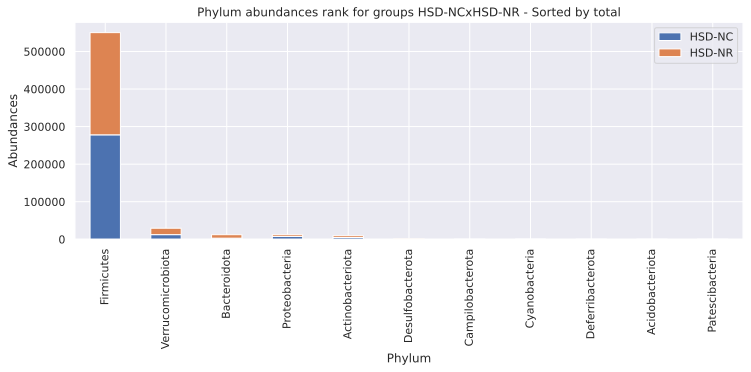

HSD-NC


<Figure size 864x288 with 0 Axes>

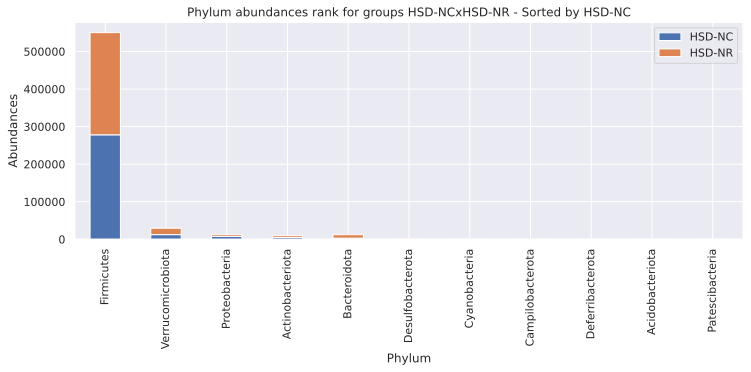

HSD-NR


<Figure size 864x288 with 0 Axes>

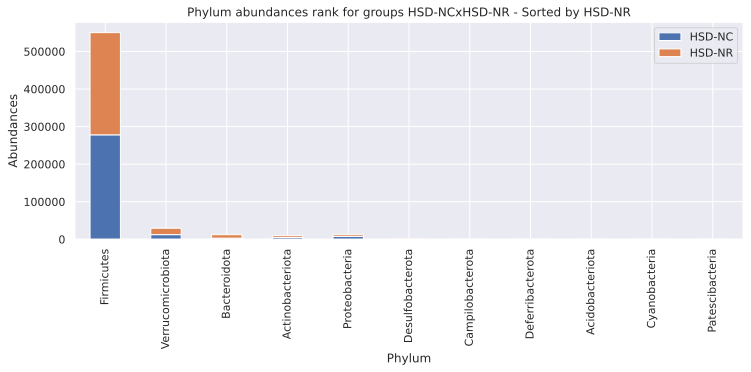

2 - Processing Class


total


<Figure size 864x288 with 0 Axes>

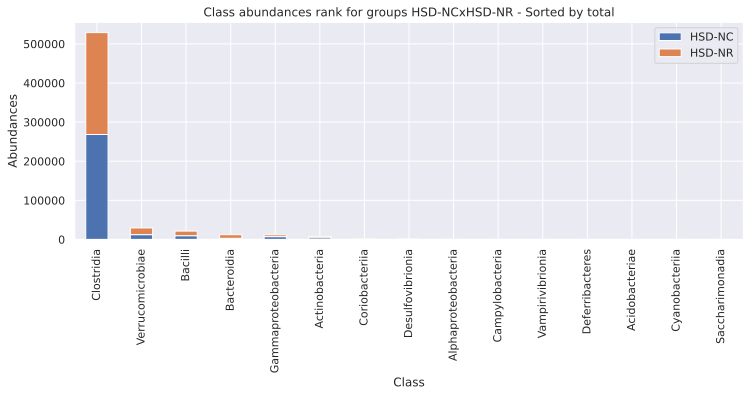

HSD-NC


<Figure size 864x288 with 0 Axes>

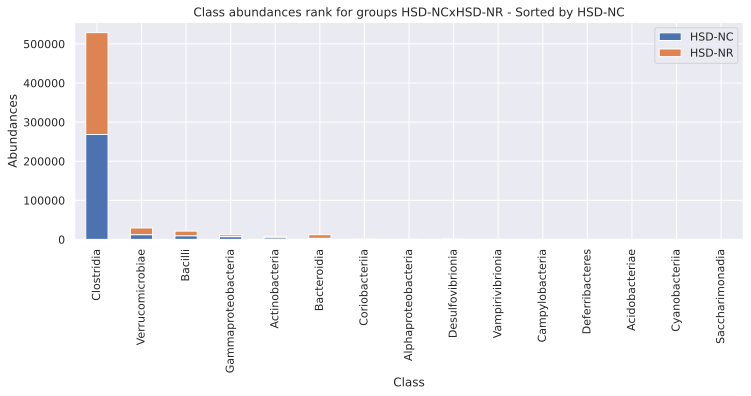

HSD-NR


<Figure size 864x288 with 0 Axes>

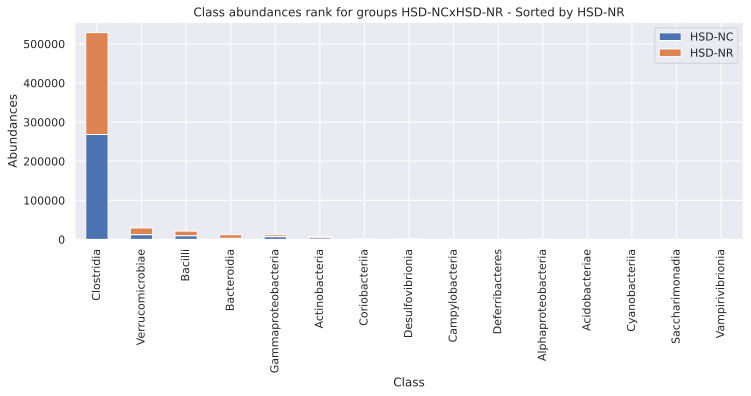

3 - Processing Order


total


<Figure size 864x288 with 0 Axes>

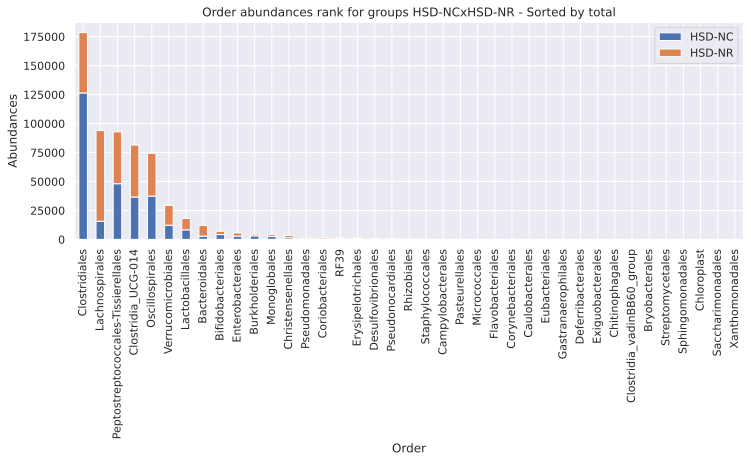

HSD-NC


<Figure size 864x288 with 0 Axes>

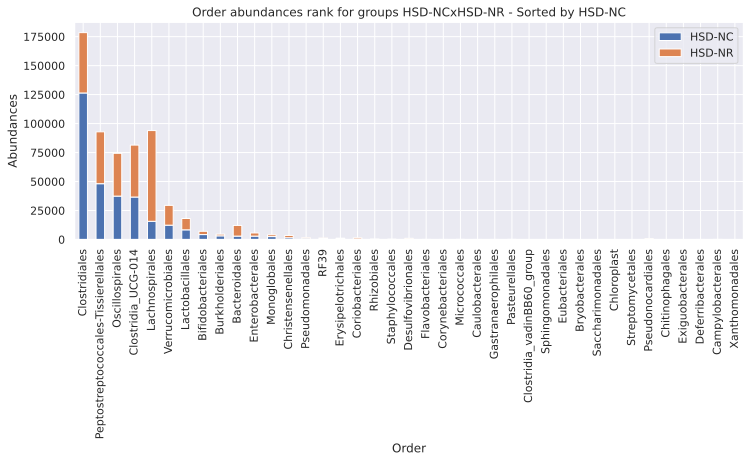

HSD-NR


<Figure size 864x288 with 0 Axes>

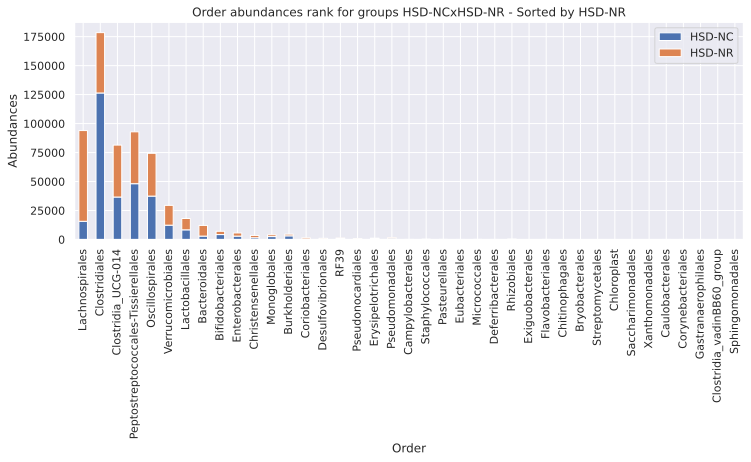

4 - Processing Family


total


<Figure size 864x288 with 0 Axes>

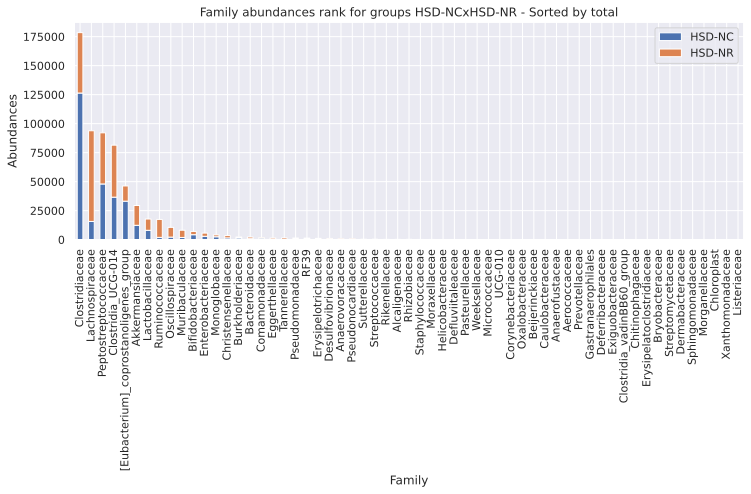

HSD-NC


<Figure size 864x288 with 0 Axes>

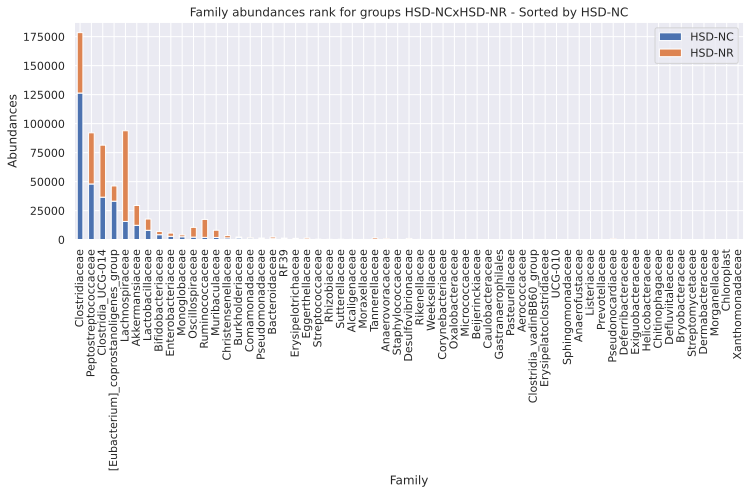

HSD-NR


<Figure size 864x288 with 0 Axes>

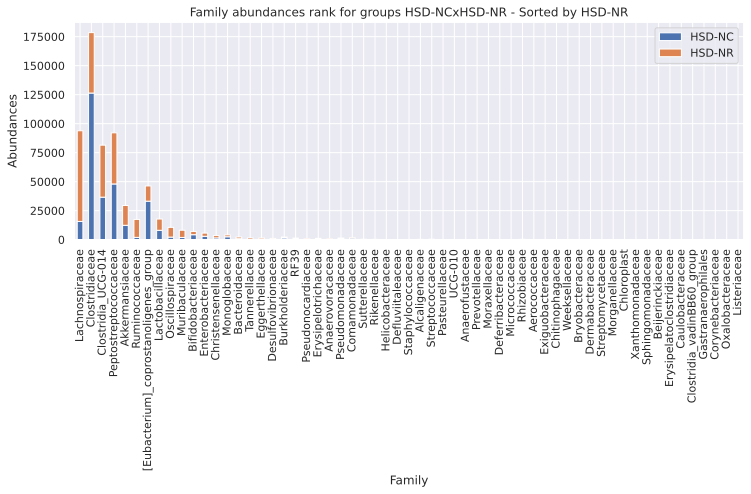

5 - Processing Genus


total


<Figure size 864x288 with 0 Axes>

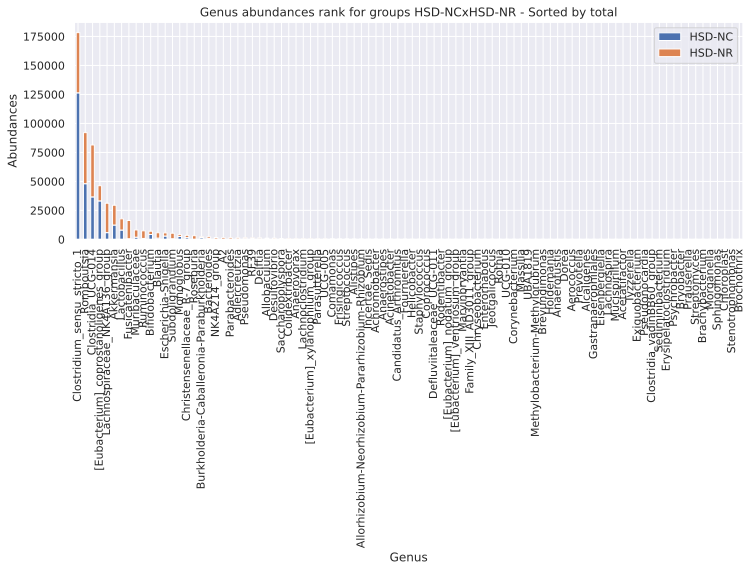

HSD-NC


<Figure size 864x288 with 0 Axes>

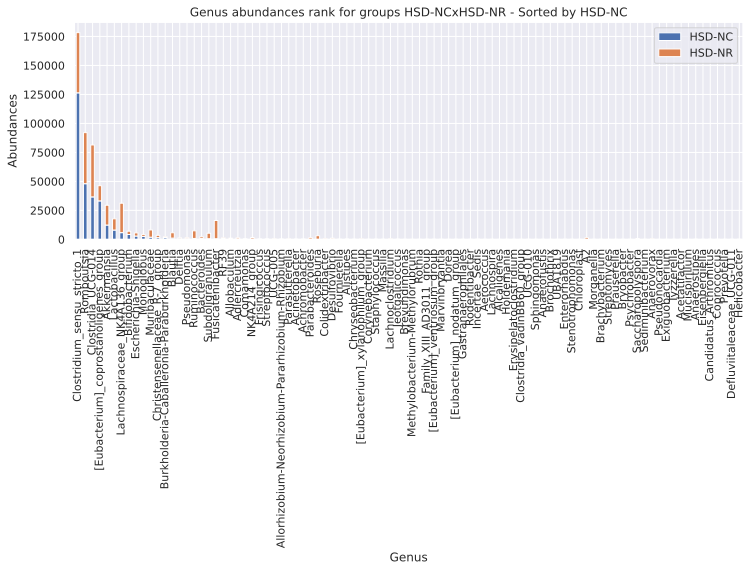

HSD-NR


<Figure size 864x288 with 0 Axes>

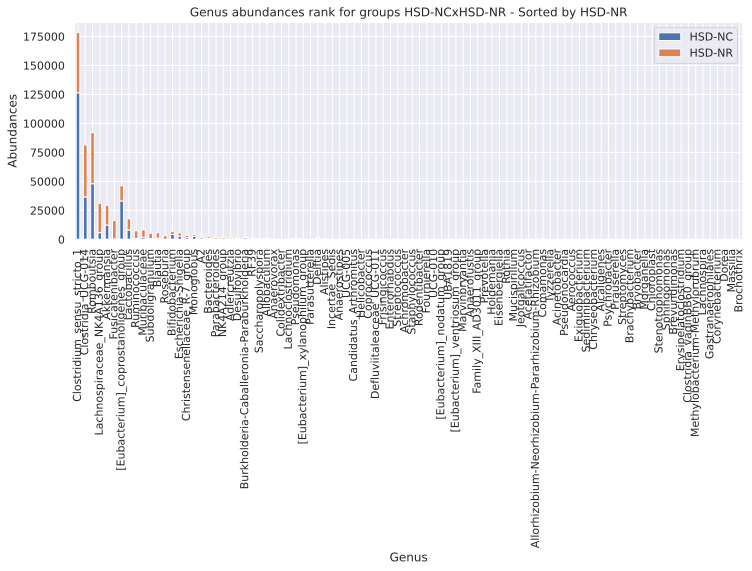

6 - Processing Species


total


<Figure size 864x288 with 0 Axes>

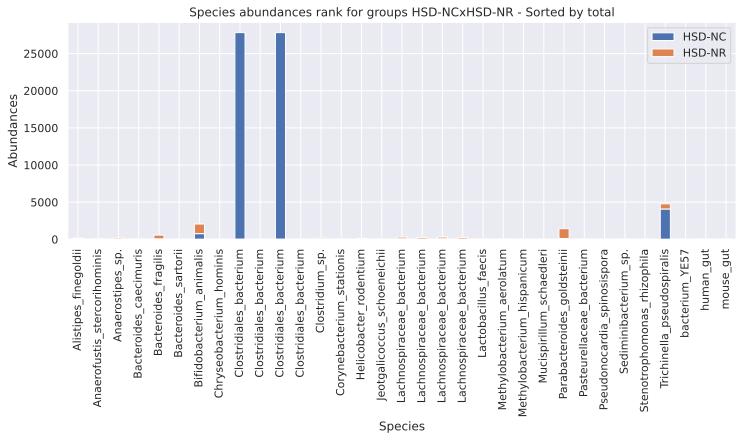

HSD-NC


<Figure size 864x288 with 0 Axes>

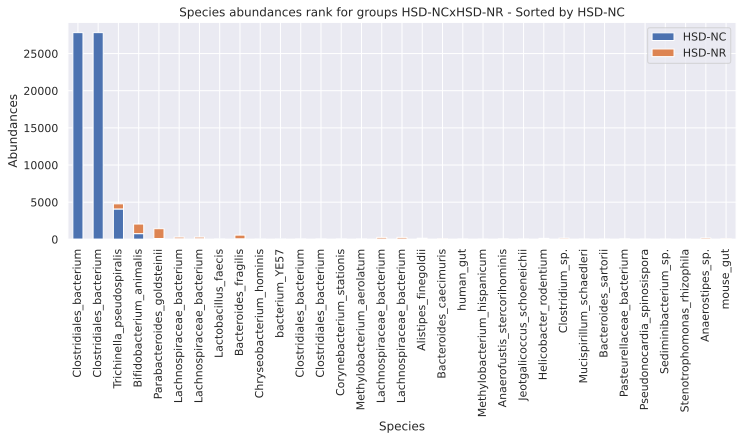

HSD-NR


<Figure size 864x288 with 0 Axes>

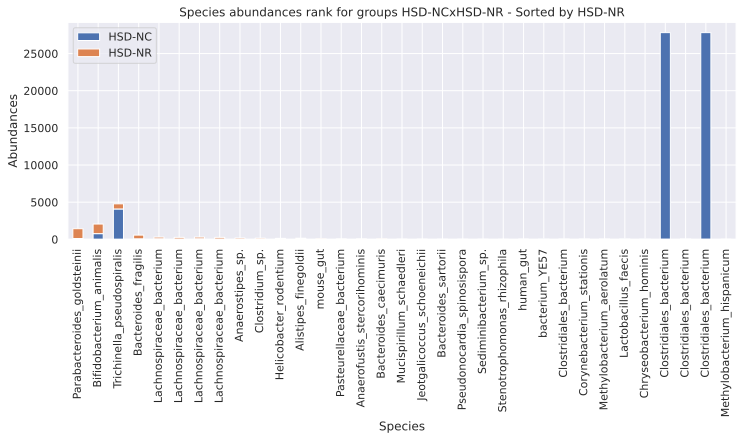

In [14]:
process_all_levels(tabs, metatax_qa, metadata_qa, groups_values, experiment_name)